# Introduction to data science: regression

[**This notebook is available on Google Colab.**](https://colab.research.google.com/drive/10WN75P4JBiLzB-I12c2qJzLtzKCAWDl_)

Classification is all about predicting discrete classes, but sometimes we want to predict quantities &mdash; continuous numerical properties with magnitude, like temperature or time.

As before, we want to select the best (i.e. optimal) model -- and, as before, this means having an objective measure of 'best' and a way to prove that you have found it. 

First we'll import some data. Again, I'm using an extract from [the Rock Property Catalog](https://subsurfwiki.org/wiki/Rock_Property_Catalog).

In [2]:
import pandas as pd

df = pd.read_csv('https://github.com/scienxlab/datasets/raw/refs/heads/main/rpc/rpc-3-imbalanced.csv')

df.head()

,RPC,Description,Lithology,Vp,Vs,Rho
0,101023,Gray Shale,shale,4953.660011,2957.260132,2.71
1,100978,Olentangy Shale,shale,3444.658279,2318.002224,2.68
2,100993,Brown Gas Shale,shale,3507.803917,2218.529940,2.56
3,101048,Shale 2 (Density is assumed constant),shale,2988.889933,1633.329988,2.60
4,100417,Tight gas shale,shale,3642.000000,2221.000000,2.46


In [3]:
df.describe().head(1)

,RPC,Vp,Vs,Rho
count,440.0,440.0,440.0,428.0


This data set contains missing values in the 'Rho' column. Let's first fill those using the Gardner equation.

In [4]:
def gardner(vp):
    """
    Compute density rho, based on P-wave velocity Vp,
    using the Gardner equation.
    """
    return 0.310 * vp**0.25

df['Rho'] = df['Rho'].fillna(df['Vp'].map(gardner))

In [5]:
df.describe().head(1)

,RPC,Vp,Vs,Rho
count,440.0,440.0,440.0,440.0


Let's select a column as `X` (input) and a `y` (target).

In [6]:
X = df[['Vp']].values
y = df['Vs'].values

## Plot the data

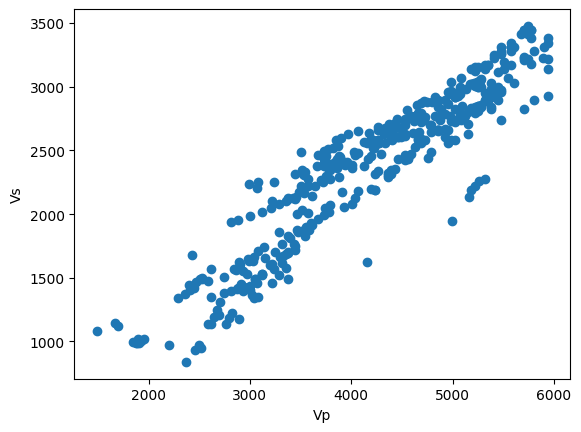

In [7]:
import matplotlib.pyplot as plt

plt.scatter(X, y)
plt.xlabel('Vp')
_ = plt.ylabel('Vs')

---
## Ridge regression

**Linear regression** is a reliable regressor. The 'vanilla' algorithm does not include any regularization (penalty for more complex models), which is sometimes what you want. But we will use regularization from the start (even though we currently only have one feature), because you will often want to apply it &mdash; and it gives us the chance to talk about regularization and hyperparameter tuning later on!

In [8]:
from sklearn.linear_model import Ridge

est = Ridge()

est.fit(X, y)

y_pred = est.predict(X)

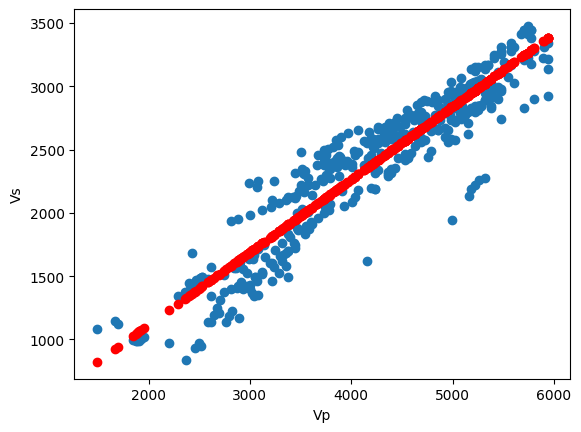

In [9]:
plt.scatter(X, y)
plt.scatter(X, y_pred, c='r')
plt.xlabel('Vp')
_ = plt.ylabel('Vs')

### Plot a line

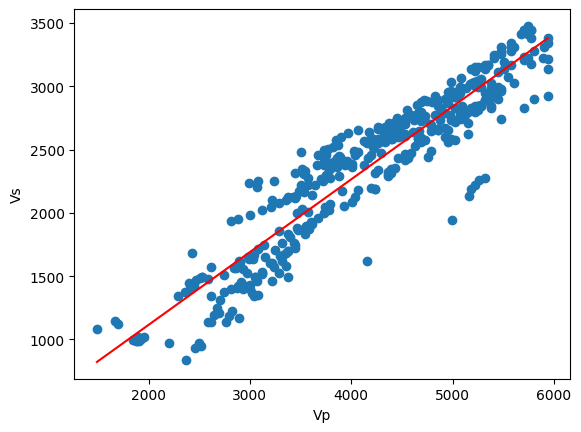

In [10]:
import numpy as np

X_model = np.linspace(np.min(X), np.max(X)).reshape(-1, 1)
y_model = est.predict(X_model)

plt.scatter(X, y)
plt.plot(X_model, y_model, 'r')
plt.xlabel('Vp')
_ = plt.ylabel('Vs')

Recall that we are fitting a model like:

$$ \Large \hat{y} = w x + b $$

We can ask for the slope ($w$) and the intercept ($b$) of our fitted line:

In [11]:
est.coef_, est.intercept_

(array([0.57508452]), np.float64(-34.59412183047607))

**❓ How can we measure the quality of our fit?**

<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;

In [12]:
from sklearn.metrics import r2_score

r2_score(y, y_pred)

0.8801226031660446

**❓ What do we think? Are we satisfied?**

<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;

## Scoring

Scores matter in all machine learning tasks. It is very common to see people reporting only **R<sup>2</sup>** for regression tasks, or only **accuracy** for classification tasks. But it is almost never enough to only look at (or report) the 'obvious' score ('obvious' might also be field specific).

The **mean squared error** was used for the optimization, but its square root, **RMS error**, is often easier to interpret because it has the same units as the original quantity.

In [13]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

mean_squared_error(y, y_pred), root_mean_squared_error(y, y_pred)

(46495.461019332535, 215.6280617622218)

The **mean absolute error** may be even more intuitive. It is also less sensitive to outliers than RMSE.

In [14]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(y, y_pred)

172.85143650411698

Let's make ourselves a small report.

In [15]:
def report(y, y_pred):
    print(f"R²: {r2_score(y, y_pred):.4f}", end='    ')
    print(f"RMSE: {root_mean_squared_error(y, y_pred):.1f}", end='    ')
    print(f"MAE: {mean_absolute_error(y, y_pred):.1f}")
    return

report(y, y_pred)

R²: 0.8801    RMSE: 215.6    MAE: 172.9


<div style="background: #e0f0ff; border: solid 2px #d0e0f0; border-radius:3px; padding: 1em; color: navy">

---

<h3>Assumptions of regression</h3>

Along with these metrics, it's essential to inspect the residuals to ensure that they are:

- Approximately normally distributed (with $0$ mean).
- Not correlated with the feature or target (or other residuals, i.e. autocorrelated).
- Homoscedastic (the variance is not correlated with inputs or output).

These conditions are assumptions of Gauss–Markov theorem, which underlies linear regression.
</div>

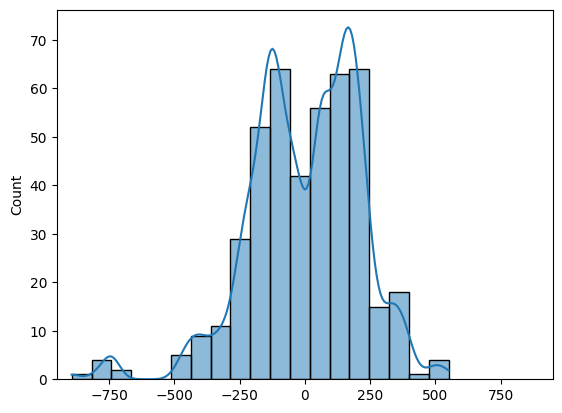

In [16]:
import seaborn as sns

sns.histplot(y - y_pred, kde=True, kde_kws={'bw_adjust':0.5})
_ = plt.xlim(-950, 950)

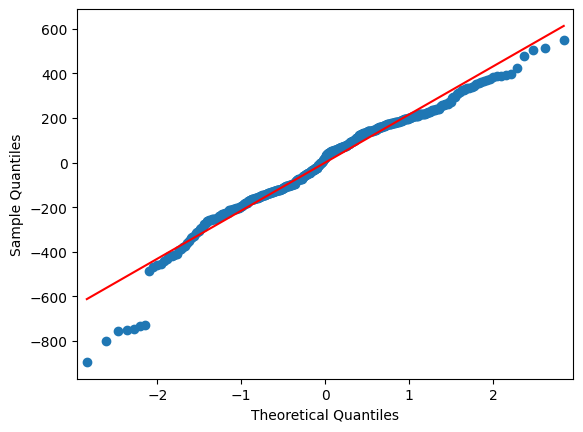

In [17]:
import statsmodels.api as sm

_ = sm.qqplot(data=(y - y_pred), line='s')

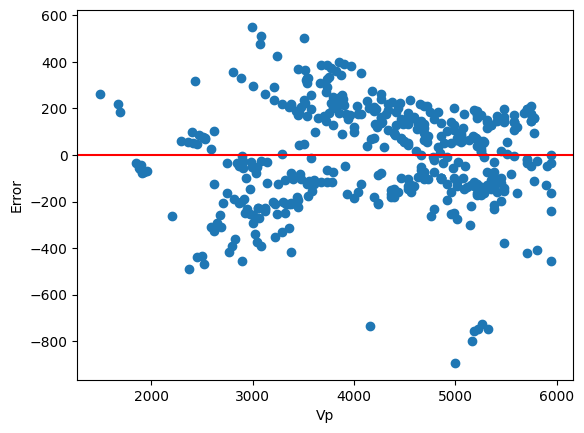

In [18]:
plt.plot(X, y - y_pred, 'o')
plt.axhline(y=0, c='r')
plt.xlabel('Vp')
_ = plt.ylabel('Error')

---

## Fair evaluation

Now that we have an evaluation criterion, we need to address another issue: fairness. Our test was not fair.

We should not train the model then check its performance only on that same training dataset. It's cheating, because in the future we'd like to predict on data that the model has never seen. So we should test the model on data it has never seen.

Let's hold out some validation data, or 'blind' data.

In [19]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((330, 1), (330,), (110, 1), (110,))

<div style="background: #e0ffe0; border: solid 2px #d0f0d0; border-radius:3px; padding: 1em; color: darkgreen">

<h3>EXERCISE</h3>

Now let's train a model _on only the training data_ and validate it properly _on only the test data_.

**❓ Do we think the score will be better or worse than before?**
</div>

In [21]:
est = Ridge()

est.fit( X_train, y_train ) 

y_pred = est.predict( X_test ) 

report( y_test, y_pred )  

R²: 0.8718    RMSE: 212.3    MAE: 174.9


Was: `R²: 0.8801    RMSE: 215.6    MAE: 172.9` (train error)

**❓ What do we need to think about when splitting? In other words: what is the most important thing about the test data?**

&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />

First and foremost, the test data must look like data we expect in the future.

We also need to think about:

- **Independence** — can you shuffle the data without losing information?
- **Identical distributions** — are both the train and test data from the same distribution?
- **Reproducibility** — what can we do to make this reproducible?

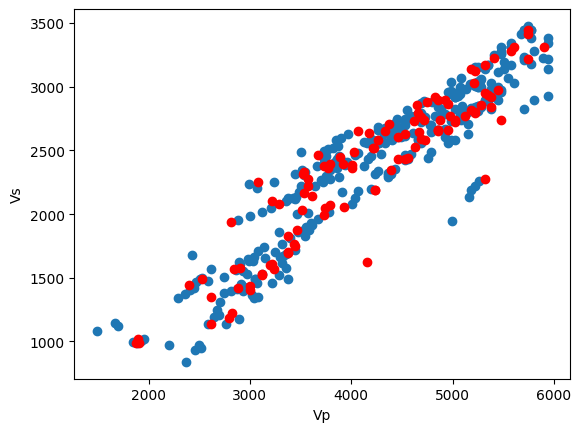

In [22]:
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, c='r')
plt.xlabel('Vp')
_ = plt.ylabel('Vs')

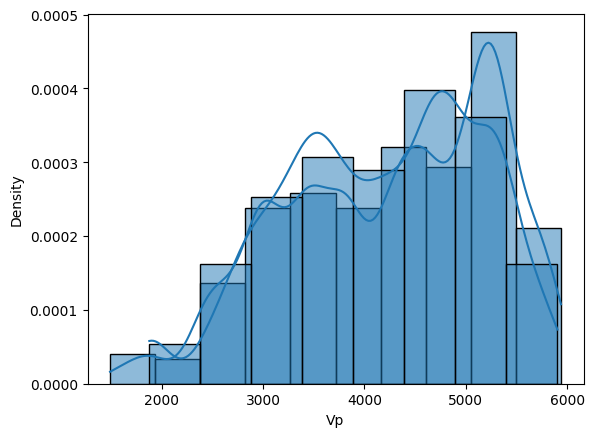

In [23]:
sns.histplot(X_train, stat='density', kde=True, kde_kws={'bw_adjust':0.5}, legend=False)
sns.histplot(X_test, stat='density', kde=True, kde_kws={'bw_adjust':0.5}, legend=False)
_ = plt.xlabel('Vp')

Let's do it in the proper reproducible way this time!

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

est = Ridge()
est.fit( X_train, y_train ) 
y_pred = est.predict( X_test )

report( y_test, y_pred )

R²: 0.8405    RMSE: 226.0    MAE: 179.4


Was: `R²: 0.8801    RMSE: 215.6    MAE: 172.9` (train error)

## How are we doing?

Let's check the model against the test data only.

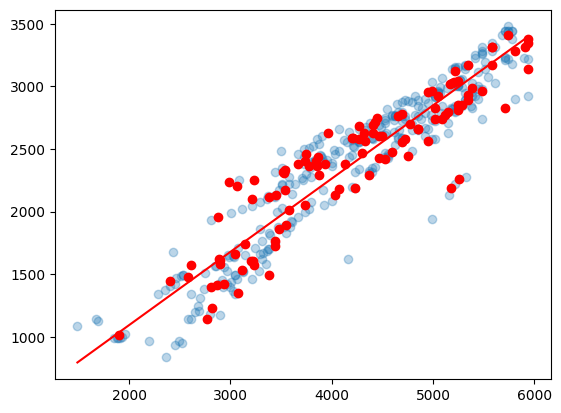

In [25]:
y_model = est.predict(X_model)

plt.scatter(X_train, y_train, alpha=0.3)
plt.scatter(X_test, y_test, c='r')
_ = plt.plot(X_model, y_model, 'r')

**❓ What could we do to improve this prediction?**

&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />

Quite a few things!

- We have another log: we could use the density as well.
- We have lithology, we could use that as well.
- We could think about whether we need to preprocess the data in any way.
- We could add nonlinear transformations and combinations of the features.
- We could tune the hyperparameter of the model, `alpha`.
- We could try other models.

🕑 If we have time, we can try some of these things.

---

## More features

We also have the rock density, `Rho`, let's use that. Now the model will be like:

$$ \Large \hat{y} = w_0 x_0 + w_1 x_1 + b $$

In [26]:
X = df[['Vp', 'Rho']].values
y = df['Vs'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

est = Ridge()
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

report(y_test, y_pred)

R²: 0.8617    RMSE: 210.5    MAE: 165.7


Was before (one feature):

`R²: 0.8405    RMSE: 226.0    MAE: 179.4`

Was originally (train error):

`R²: 0.8801    RMSE: 215.6    MAE: 172.9`

One downside is that it is now a bit harder to draw than it was. but we won't fix it as it's just about to get worse...

---
## Non-linearity

Linear regression is linear **in the parameters**, but we can model non-linear relationships in the data by adding non-linear transformations of the data. In particular, we will add the squares of the features, and the **interactions** of the features (their products, basically).

We can do this with **polynomial expansion** as follows:

In [27]:
np.set_printoptions(precision=3)
X[:5]

array([[4.954e+03, 2.710e+00],
       [3.445e+03, 2.680e+00],
       [3.508e+03, 2.560e+00],
       [2.989e+03, 2.600e+00],
       [3.642e+03, 2.460e+00]])

In [28]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
X_ = poly.fit_transform(X)
X_[:5]

array([[4.954e+03, 2.710e+00, 2.454e+07, 1.342e+04, 7.344e+00],
       [3.445e+03, 2.680e+00, 1.187e+07, 9.232e+03, 7.182e+00],
       [3.508e+03, 2.560e+00, 1.230e+07, 8.980e+03, 6.554e+00],
       [2.989e+03, 2.600e+00, 8.933e+06, 7.771e+03, 6.760e+00],
       [3.642e+03, 2.460e+00, 1.326e+07, 8.959e+03, 6.052e+00]])

Now we have:

$$ \Large \hat{y} = w_0 x_0 + w_1 x_1 + w_2 x_0^2 + w_3 x_0 x_1 + w_4 x_1^2 + b $$

So the model will have six parameters.

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X_, y, random_state=42)

est = Ridge()
est.fit(X_train, y_train)
y_pred = est.predict(X_test)

report(y_test, y_pred)

R²: 0.8656    RMSE: 207.5    MAE: 163.0


/home/vscode/.local/lib/python3.11/site-packages/sklearn/linear_model/_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=3.78562e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Was previously:

`R²: 0.8617    RMSE: 210.5    MAE: 165.7`

Let's look at the coefficients now.

In [30]:
est.coef_, est.intercept_

(array([ 7.840e-01,  8.772e+01, -1.320e-05, -5.836e-02,  1.341e+02]),
 np.float64(-1085.6994158243988))

**❓ Big coefficient means big effect, right? Can we interpret these as importances?**

<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;

---

## Scale matters

Let's look at the first few rows of the data (before expansion):

In [31]:
X[:5]

array([[4.954e+03, 2.710e+00],
       [3.445e+03, 2.680e+00],
       [3.508e+03, 2.560e+00],
       [2.989e+03, 2.600e+00],
       [3.642e+03, 2.460e+00]])

The units of these columns are m/s and g/cm<sup>3</sup>, which have very different magnitudes for rocks.

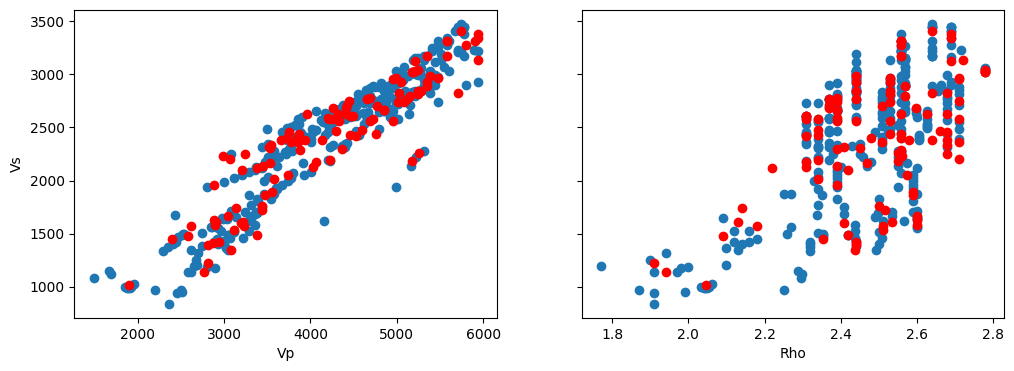

In [32]:
fig, (axl, axr) = plt.subplots(figsize=(12, 4), ncols=2, sharey=True)
axl.plot(X_train[:, 0], y_train, 'o')
axl.plot(X_test[:, 0], y_test, 'ro')
axr.plot(X_train[:, 1], y_train, 'o')
axr.plot(X_test[:, 1], y_test, 'ro')
axl.set_xlabel('Vp')
axl.set_ylabel('Vs')
_ = axr.set_xlabel('Rho')

We're really only interested in the _distributions_ of the data:

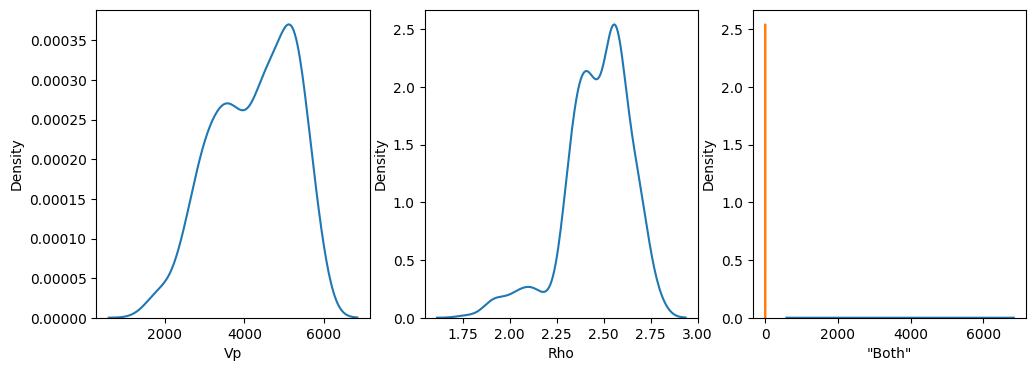

In [33]:
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(12, 4), ncols=3)
sns.kdeplot(X[:, 0], ax=ax0)
sns.kdeplot(X[:, 1], ax=ax1)
sns.kdeplot(X[:, 0], ax=ax2)
sns.kdeplot(X[:, 1], ax=ax2) 
ax0.set_xlabel('Vp')
ax1.set_xlabel('Rho')
_ = ax2.set_xlabel('"Both"')

## Standardize the data

It's essential to train some machine learning algorithms on scaled data, for example on the Z-scores of your data, i.e. zero mean, unit variance. This ensures that the different scales of the features is not causing a problem.

For features distributed uniformly, or with strong min/max constraints, another strategy like normalization (e.g. in (0, 1) or (-1, 1)) might be better.

**❓ Standardization needs the mean and variance of the data... which dataset shall we measure these stats on?**

<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;<br />&nbsp;

In [34]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

scaler.fit(X_train)

X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

This doesn't change how the data are distributed:

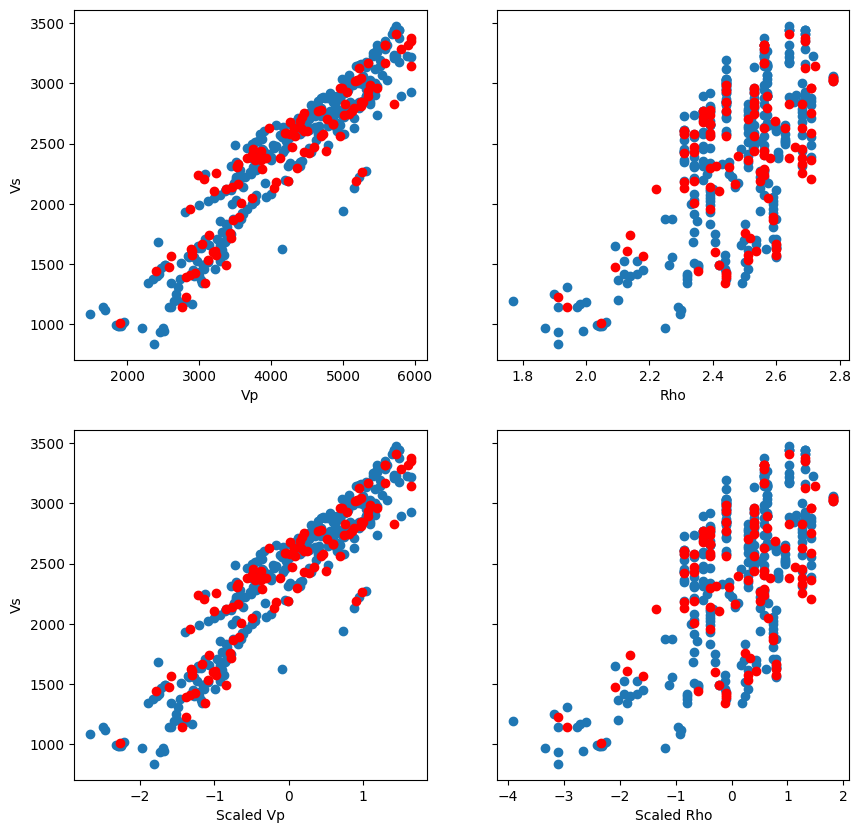

In [35]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(figsize=(10, 10), ncols=2, nrows=2, sharey=True)
ax0.plot(X_train[:, 0], y_train, 'o')
ax0.plot(X_test[:, 0], y_test, 'ro')
ax1.plot(X_train[:, 1], y_train, 'o')
ax1.plot(X_test[:, 1], y_test, 'ro')
ax2.plot(X_train_sc[:, 0], y_train, 'o')
ax2.plot(X_test_sc[:, 0], y_test, 'ro')
ax3.plot(X_train_sc[:, 1], y_train, 'o')
ax3.plot(X_test_sc[:, 1], y_test, 'ro')
ax0.set_xlabel('Vp')
ax0.set_ylabel('Vs')
ax1.set_xlabel('Rho')
ax2.set_xlabel('Scaled Vp')
ax2.set_ylabel('Vs')
_ = ax3.set_xlabel('Scaled Rho')

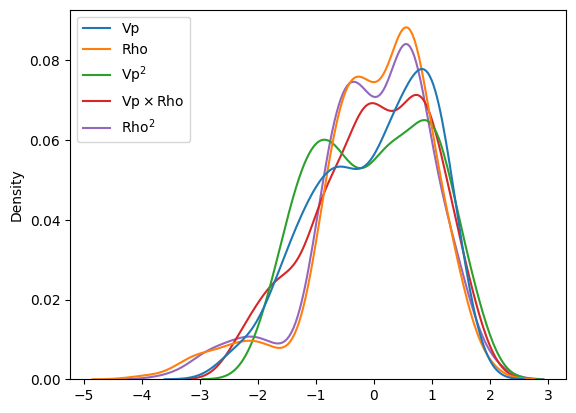

In [36]:
sns.kdeplot(X_train_sc)
_ = plt.legend([r'$\text{Rho}^2$',r'$\text{Vp}\times\text{Rho}$',r'$\text{Vp}^2$', 'Rho','Vp'], reverse=True)

Now we can re-fit the model and look at the scores.

In [37]:
est = Ridge()
est.fit(X_train_sc, y_train)
y_pred = est.predict(X_test_sc)

report(y_test, y_pred)

R²: 0.8629    RMSE: 209.5    MAE: 163.1


Was:

`R²: 0.8656    RMSE: 207.5    MAE: 163.0`


The quality of the prediction does not change by much (some models, like linear regression *without* regularization are in fact invariant to scaling, 
<br> and should in theory not change at all), but the coefficients do change!

In [38]:
est.coef_, est.intercept_

(array([ 503.114,  220.714,  -76.077,  138.306, -154.086]),
 np.float64(2407.0908739363604))

**❓ Can we now interpret these coefficients as importances?**

<div style="background: #e0f0ff; border: solid 2px #d0e0f0; border-radius:3px; padding: 1em; color: navy">

That would depend on who you ask. Some people think it is okay to do that, others would argue you should not interpret the coefficients of the regularized model. <br>
Personally, I think you should be somewhat careful equating large coefficients with importance, due to a few reason:
- You are now deciding importance based on a scaling that is a product of your sample (train data), making it prone to variability.
- You can get large coefficents on features with low variance (near-constant), would you still call it an important feature?
- Correlated features will also heavily affect your coefficients (and in real life, your data is unfortunately *almost never* uncorrelated), making interpreting them as importance very tricky. (e.g. if two features $X, Y$ are heavily correlated, they may both get large coefficents, while a third uncorrelated feature $Z$ gets lower scores. Removing $Y$ may have minimal effect on your prediction error as long as you keep $X$, but removing $Z$ might result in significantly worse performance since it explains something completely different about your data!)  
</div>

### Should you scale the target?

I have not been able to get a clear answer on this, but in general, I have not seen many reasons (practical nor theoretical) in favor of scaling the target . The exception seems to be with neural networks (the reason being that large error values may not backpropagate properly during training).

### Be careful however!

Solving one problem gives us a new one. It is now essential to scale the data now before inference -- although the model will happily make (terrible) predictions.

In [39]:
X_train[0]

array([4.790e+03, 2.570e+00, 2.294e+07, 1.231e+04, 6.605e+00])

In [40]:
est.predict([X_train[0]])

array([-1.741e+09])

This is known as an "out of distribution" or OOD error, and it's a classic pitfall in machine learning.

---

## Put everything in a pipeline

This is the most flexible way to compose data pipelines in `sklearn`. It is better than implementing everything individually in a stepwise manner.

For now, it won't change anything.

In [41]:
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(StandardScaler(), Ridge())

pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

report(y_test, y_pred)

R²: 0.8629    RMSE: 209.5    MAE: 163.1


## Hyperparameter tuning

It is sensible to use cross-validation when tuning hyperparameters. Using the test data for tuning will overfit to the train-test split.

In [42]:
from sklearn.model_selection import cross_validate, KFold, StratifiedKFold
#from sklearn.metrics import make_scorer

pipe = make_pipeline(StandardScaler(), Ridge())
kf = KFold(n_splits=5).split(X_train, y_train)

cross_validate(pipe,
               X_train, y_train,
               scoring='neg_root_mean_squared_error',
               cv=kf,
               return_train_score=True,
              )

{'fit_time': array([0.002, 0.002, 0.001, 0.001, 0.002]),
 'score_time': array([0.001, 0.001, 0.   , 0.001, 0.001]),
 'test_score': array([-179.216, -162.221, -225.139, -199.396, -218.258]),
 'train_score': array([-200.475, -204.123, -188.538, -196.261, -189.957])}

We have only used Vp and Rho to predict Vs, which makes the above approach fine. However, we do have a column with lithology classes as well. This class is categorical and *not* very well balanced! Including this as a feature then randomly splitting data with CV into k folds might result in heavily imbalanced lithology classes in each fold. StratifiedKFold aims to correct this! 

In [43]:
df['Lithology'].value_counts()

Lithology
shale        200
dolomite     200
limestone     40
Name: count, dtype: int64

In [44]:
df_train, df_test = train_test_split(df, stratify=df['Lithology'], random_state=42)

pipe = make_pipeline(StandardScaler(), Ridge())
skf = StratifiedKFold(n_splits=5).split(X_train, df_train['Lithology'])

cross_validate(pipe,
               X_train, y_train,
               scoring='neg_root_mean_squared_error',
               cv=skf,
               return_train_score=True,
              )

{'fit_time': array([0.001, 0.001, 0.001, 0.001, 0.001]),
 'score_time': array([0.001, 0.001, 0.001, 0.   , 0.   ]),
 'test_score': array([-174.999, -166.485, -229.69 , -197.3  , -214.598]),
 'train_score': array([-201.269, -203.345, -187.813, -195.934, -190.955])}

Now we can use a loop to try lots of different values of `alpha`:

In [45]:
alphas = np.logspace(-4, 2, 13)
alphas

array([1.000e-04, 3.162e-04, 1.000e-03, 3.162e-03, 1.000e-02, 3.162e-02,
       1.000e-01, 3.162e-01, 1.000e+00, 3.162e+00, 1.000e+01, 3.162e+01,
       1.000e+02])

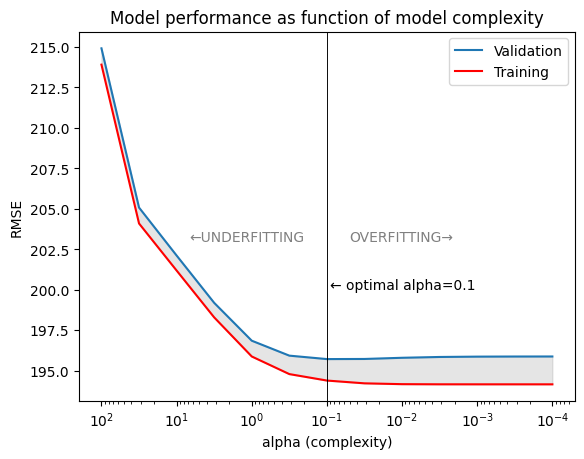

In [46]:
mean_val, mean_train = [], []
for alpha in alphas:
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    kf = KFold().split(X_train, y_train)
    cross_val = cross_validate(pipe, X_train, y_train, scoring='neg_root_mean_squared_error', cv=kf, return_train_score=True)
    mean_val.append(-np.mean(cross_val['test_score']))
    mean_train.append(-np.mean(cross_val['train_score']))

alpha_opt = alphas[np.argmin(mean_val)]

plt.plot(alphas, mean_val, label='Validation')
plt.plot(alphas, mean_train, c='r', label='Training')
plt.fill_between(alphas, mean_val, mean_train, alpha=0.2, color='grey')
plt.xlabel('alpha (complexity)')
plt.ylabel('RMSE')
plt.xscale('log')
plt.yticks(np.arange(195,215+1, 2.5))
plt.title('Model performance as function of model complexity')
plt.axvline(alpha_opt, c='k', lw=0.67)
plt.text(0.9*alpha_opt, 200, f"← optimal alpha={alpha_opt:.1f}")
plt.text(2*alpha_opt, 203, f"←UNDERFITTING", horizontalalignment='right', c='gray')
plt.text(0.5*alpha_opt, 203, f"OVERFITTING→", horizontalalignment='left', c='gray')
plt.legend()
plt.gca().invert_xaxis()

<div style="background: #e0f0ff; border: solid 2px #d0e0f0; border-radius:3px; padding: 1em; color: navy">

This curve highligths an essential part training machine learning models: the **bias–variance trade-off!**. The MSE can be decomposed into a *variance* and a *bias* term (technically also an irreducible error, but we cannot do much that one. [See e.g. this plot on Wikipedia for a sketch of the bias-variance trafe-off](https://en.wikipedia.org/wiki/Bias%E2%80%93variance_tradeoff#/media/File:Bias_and_variance_contributing_to_total_error.svg)). Models with high complexity tend to have high variance (think about fitting an $n-1$-degree polynomial through $n$ points and then extrapolating), but low bias. Simpler models have low variance but high bias (they are unable to capture sophisticated or more complex relationships in your data). Finding a model where the trade-off is just right is what data scientists aim for, and explains why the most complex model is not necessarily the best choice!
</div>

---
## Categorical features

Turns out the different lithologies have quite different rock physics characteristics. It makes a lot of sense to account for this in the model. You might think you want to train a different model for each lithology, but this is not necessary. It is sufficient to introduce the lithology variable into `X`, using 'dummy encoding'. 

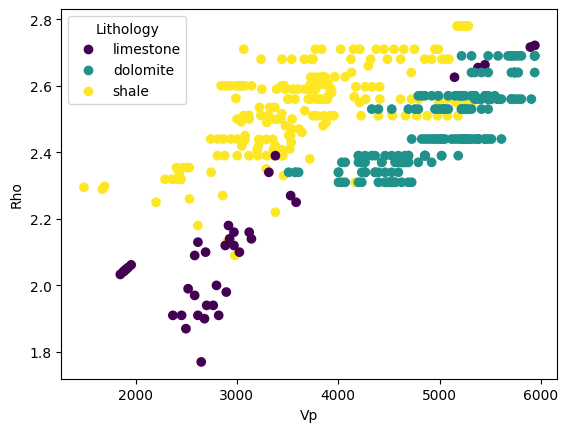

In [47]:
LITHS = ['limestone', 'dolomite', 'shale']

def lith_index(y):
    return [LITHS.index(lith) for lith in y]

fig, ax = plt.subplots()

scatter = ax.scatter(*X.T, c=lith_index(df['Lithology']))
ax.set_xlabel('Vp')
ax.set_ylabel('Rho')
handles, labels = scatter.legend_elements()
legend = ax.legend(handles = handles, labels = LITHS, title="Lithology")

For more on how to do this, check out [this notebook](https://github.com/agilescientific/geocomputing/blob/develop/prod/Linear_regression.ipynb), and look for the **Take lithology into account** section.

---

## Carry on exploring!

<div style="background: #e0ffe0; border: solid 2px #d0f0d0; border-radius:3px; padding: 1em; color: darkgreen">

- How can you add Lithology to the features? Would it improve the prediction quality?
- Choose another algorithm to try a prediction with, and implement it in a pipeline. For example, try KNN.
- Choose a hyperparameter of the new algorithm and tune it. (If you have done this kind of thing before, try tuning 2 or 3 hyperparameters with grid or random search.)
</div>

## Test

When you have tuned the predictor and are satisfied that it is as good as it can be, you can test against the holdout set.

In [48]:
alpha_opt = alphas[np.argmin(mean_val)]

pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha_opt))

pipe.fit(X_train, y_train)
                    
y_pred = pipe.predict(X_test)

report(y_test, y_pred)

R²: 0.8634    RMSE: 209.2    MAE: 162.2


Was (before scaling and tuning hyperparameters):

`R²: 0.8656    RMSE: 207.5    MAE: 163.0`

There might still have been some room for improvement here! But let's not cheat by overfitting ourselves to the test-set, and consider ourselves satisfied for now. Also, keeping the 'old' model and trading 1 point of MSE for an ill-conditioned matrix and potential optimization issues might not be such a good idea anyway! <br>
Remember we said the residuals should meet certain conditions? Let's check them again:

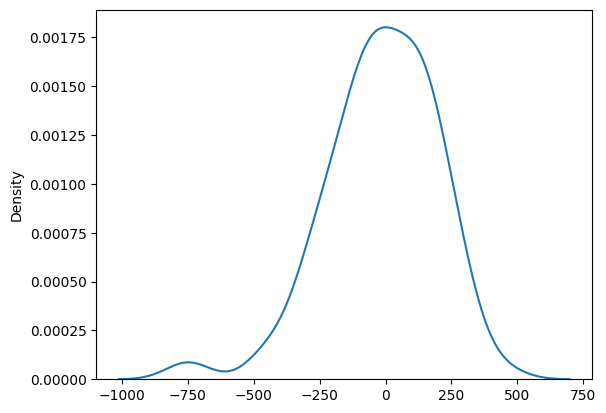

In [49]:
_ = sns.kdeplot(y_test - y_pred)

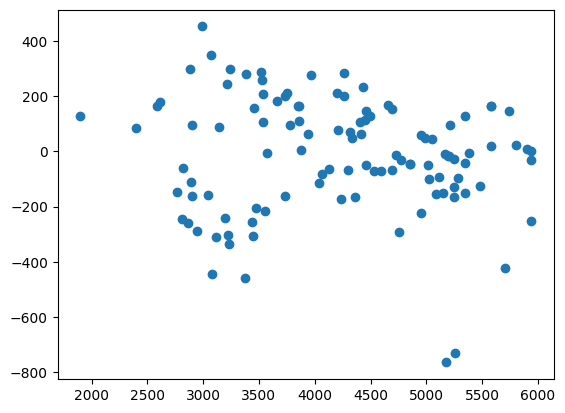

In [50]:
_ = plt.plot(X_test[:, 0], y_test - y_pred, 'o')

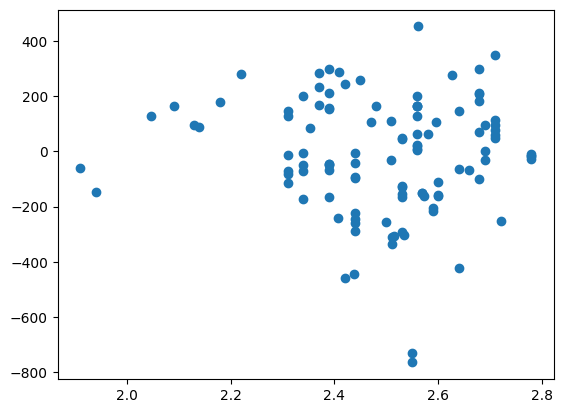

In [51]:
_ = plt.plot(X_test[:, 1], y_test - y_pred, 'o')

If you are satisfied (think hard about what this means... you really have to decide before you start the model fitting process) then you are ready to fit the final model. If not, you must start all over again.

## Using this model

We do not want to use this model &mdash; if we like its performance then we should now retrain it on all the data. Presumably, this new model will be at least as good as the one trained on the training set, we just don't have a way to check it now 😬

In [52]:
scaler = StandardScaler().fit(X_)
X_sc = scaler.transform(X_)
est = Ridge(alpha=alpha_opt).fit(X_sc, y)

There is no way for us to test this model, but we should monitor it in production.

<div style="background: #e0f0ff; border: solid 2px #d0e0f0; border-radius:3px; padding: 1em; color: navy">

---

<h3>Takeaways</h3>

There are lots, but here are a few.

- **Machine learning is programming.** For now, for science and engineering applications, there is no way around this. Automatic machine learning is not a thing, at least not yet, not for us.
- **Learn about the algorithms you apply.** For linear regression, you need to know about its cost function, its assumptions, and regularization.
- **Give a lot of thought to how to fairly test your model.** Start by thinking about how it will be applied.
- **Scale your features if applicable.** It usually doesn't hurt and sometimes it's essential.
- **Consider using polynomial expansion on regression tasks.** It may often improve your model, but be careful about overfitting and increasing model complexity.
- **Use pipelines in `sklearn`.** You will avoid a lot of headaches and gotchas with preprocessing your data.
- **Use regularization.** It usually makes sense for predictive applications, but make sure you understand how it works and note that L2 ('ridge') regularization may not be the best strategy for your application.
- **Use appropriate measures of performance.** For example, make sure your metrics are compatible with the loss function.
- **Check that the assumptions of linear regression hold for your solution.**
</div>

<hr />

<p style="color:gray"> adapted from &copy; 2025 Matt Hall / Equinor CC BY.</p>